In [ ]:
%pip install numpy pandas plotly scikit-learn tqdm umap-learn torch tensorflow keras transformers matplotlib scikit-learn

# Muiscal Instruments classification, and topic related data analysis
This notebook consists of Analyzing the dataset of Musical Instruments photos. First the images are embedded using the generic model (microsoft ResNet). Then fine-tuned EfficientNet model is used. The notebook uses dataset from kaggle (https://www.kaggle.com/datasets/gpiosenka/musical-instruments-image-classification).

In [1]:
from pathlib import Path
from typing import Any, Literal, List, Union
from tqdm.notebook import tqdm
import os

from transformers import AutoModel

import torch

import numpy as np
from numpy.typing import NDArray
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, adjusted_rand_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering

from umap import UMAP

import tensorflow as tf
import keras
from keras import layers

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from scipy.spatial import ConvexHull

from PIL import Image
from IPython import display

import kagglehub

import random

from transformers import AutoFeatureExtractor, AutoModel

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

import warnings
warnings.filterwarnings("ignore")

# Dataset download and preperation

In [5]:
path = kagglehub.dataset_download("gpiosenka/musical-instruments-image-classification")
BASE_DIR = path
if IN_COLAB:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "vscode"

In [6]:
instrument_idxs = {}
idx_instruments = {}

with open('instruments.csv', 'r') as f:
    for line in f:
        idx, instrument = line.strip().split(',')
        instrument_idxs[instrument] = int(idx)
        idx_instruments[int(idx)] = instrument
        

In [7]:
image_paths_train = []
image_paths_test = []
image_paths_validate = []
labels_train = []
labels_test = []
labels_validate = []

file_list = os.listdir(os.path.join(BASE_DIR, "train"))

for instrument in file_list:
    idx = instrument_idxs[instrument]
    for img in os.listdir(os.path.join(BASE_DIR, "train", instrument)):
        image_paths_train.append(os.path.join(BASE_DIR, "train", instrument, img))
        labels_train.append(idx)
    for img in os.listdir(os.path.join(BASE_DIR, "test", instrument)):
        image_paths_test.append(os.path.join(BASE_DIR, "test", instrument, img))
        labels_test.append(idx)
    for img in os.listdir(os.path.join(BASE_DIR, "valid", instrument)):
        image_paths_validate.append(os.path.join(BASE_DIR, "valid", instrument, img))
        labels_validate.append(idx)
        

image_paths_train = np.array(image_paths_train)
image_paths_test = np.array(image_paths_test)
image_paths_validate = np.array(image_paths_validate)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)
labels_validate = np.array(labels_validate)

# Useful functions
First, we will declare some fuctions that will be helpful later

In [8]:
def project_vectors(data: NDArray, technique: str = "tsne", **options):
    if technique == "pca":
        transformer = PCA(**options)
    elif technique == "tsne":
        transformer = TSNE(**options)
    elif technique == "umap":
        transformer = UMAP(**options)
    else:
        raise ValueError(
            f"Invalid technique: {technique}. Choose from 'pca', 'tsne', or 'umap'."
        )

    transformed_data = transformer.fit_transform(data)
    return transformed_data

In [9]:
def cluster_df(df, embeddings, clusters_num = 30) -> None:
    kmeans = KMeans(n_clusters=clusters_num, random_state=0)
    kmeans_labels = kmeans.fit_predict(embeddings)

    AC = AgglomerativeClustering(n_clusters=clusters_num)
    AC_labels = AC.fit_predict(embeddings)

    ari_kmeans = adjusted_rand_score(labels_validate, kmeans_labels)
    ari_AC = adjusted_rand_score(labels_validate, AC_labels)

    df['KMeans Cluster'] = kmeans_labels.astype(str)
    df['AC Cluster'] = AC_labels.astype(str)

    print(f'KMeans ari: {ari_kmeans}')
    print(f'AC ari: {ari_AC}')

def show_clusters(df, title, method: Literal["KMeans", "AC"] = 'KMeans'):

    if method not in ['KMeans', 'AC']:
        raise ValueError("Use either KMeans or AC as method")

    fig_kmeans = px.scatter(
        df,
        x='x',
        y='y',
        color='instrument',
        title=title
    )

    # Add convex hulls
    for cluster in df[f'{method} Cluster'].unique():
        cluster_points = df[df[f'{method} Cluster'] == cluster][['x', 'y']].values
        if len(cluster_points) < 3:
            # ConvexHull requires at least 3 points
            continue
        hull = ConvexHull(cluster_points)
        hull_pts = cluster_points[hull.vertices]
        hull_pts = np.append(hull_pts, [hull_pts[0]], axis=0)  # Close the loop

        fig_kmeans.add_trace(go.Scatter(
            x=hull_pts[:, 0],
            y=hull_pts[:, 1],
            mode='lines',
            line=dict(color='rgba(0,0,0,0.3)', width=2),
            fill='toself',
            fillcolor='rgba(0,0,0,0.1)',
            hoverinfo='skip',
            showlegend=False
        ))

    fig_kmeans.show()

# Image Embeddings using Microsoft ResNet-50 model

In [10]:
def generate_image_embeddings(image_path: str | Path, model_name: str = "microsoft/resnet-50"):
    image = Image.open(image_path)

    #Some photos are grey scaled. Feture extractor expects 3 channel image
    if image.mode != 'RGB':
        image = image.convert('RGB')

    feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    inputs = feature_extractor(images=image, return_tensors="pt")


    with torch.no_grad():
        outputs = model(**inputs)

    if hasattr(outputs, 'pooler_output'):
        embeddings = outputs.pooler_output.numpy()
    else:
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()

    return embeddings.squeeze()

In [11]:
image_embeddings = []
for img in tqdm(image_paths_validate):
    embeddings = generate_image_embeddings(img)
    image_embeddings.append(embeddings)

  0%|          | 0/150 [00:00<?, ?it/s]

In [12]:
scaler = MinMaxScaler()
norm_image_embeddings = scaler.fit_transform(image_embeddings)
reduced_image_embeddings = project_vectors(np.array(norm_image_embeddings), technique="umap", n_components=2, random_state=42)
reduced_image_embeddings_pca = project_vectors(np.array(norm_image_embeddings), technique="pca", n_components=2, random_state=42)

In [13]:
df_embeddings = pd.DataFrame(reduced_image_embeddings, columns=["x", "y"])
df_embeddings["instrument"] = [idx_instruments[i] for i in labels_validate]

df_embeddings_pca = pd.DataFrame(reduced_image_embeddings_pca, columns=["x", "y"])
df_embeddings_pca["instrument"] = [idx_instruments[i] for i in labels_validate]

In [14]:
cluster_df(df_embeddings, reduced_image_embeddings)

KMeans ari: 0.6429622943597348
AC ari: 0.6566892848838438


In [15]:
show_clusters(df_embeddings, 'KMeans Clustering of ResNet embeddings with UMAP', 'KMeans')

# Observations
1. There are two class-pairs that were connected into one clusters:
    - bongo drums and drums
    - clavichord and piano

    Both of theese pairs consist of intstruments that are similar-looking.

2. ARI is equal to 0.65, which is pretty good score, for high amount of classes (30), and non-specific model

In [16]:
cluster_df(df_embeddings_pca, reduced_image_embeddings_pca)

KMeans ari: 0.25423193322026005
AC ari: 0.27014835958698946


In [17]:
show_clusters(df_embeddings_pca, 'Agglomerative Clustering of ResNet embeddings with PCA', 'AC')

# Observations
Despite having much lower ACI, PCA preserves global structures and allows us to get more insight.
- Instruments that are simillar are often put next to each others:
    - Guitar, Banjo, Dulcimer
    - Drums, Bongo drums
    - Trumpet, Trombone, Tuba

# Using dedicated pre-trained model
## Model accuracy analysis

In [18]:
def load_and_preprocess_image(image_path: Union[str, Path], target_size=(224, 224)) -> np.ndarray:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)  # Resize as needed
    image_array = np.array(image)
    return image_array

def generate_image_embeddings_with_keras(
        image_paths: List[Union[str, Path]],
        keras_model_path: str = "model.keras",
        batch_size: int = 1,
        target_size=(224, 224)
) -> np.ndarray:
    
    model = tf.keras.models.load_model(keras_model_path)
    all_embeddings = []

    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = [load_and_preprocess_image(path, target_size) for path in batch_paths]
        batch_tensor = np.stack(batch_images, axis=0)

        embeddings = model.predict(batch_tensor, verbose=0)
        all_embeddings.append(embeddings)

    return np.vstack(all_embeddings).squeeze()

image_embeddings = generate_image_embeddings_with_keras(image_paths_validate, keras_model_path="model.keras", batch_size=16)

  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
print(f'Accuracy score: {accuracy_score(labels_validate, np.argmax(image_embeddings, axis=1))}')

Accuracy score: 0.98


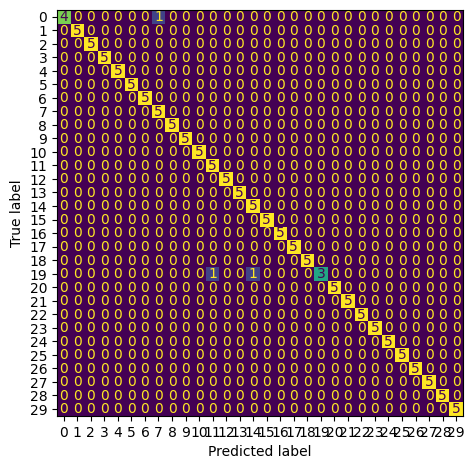

In [20]:
_, count = np.unique(labels_validate, return_counts=True)
cm1 = ConfusionMatrixDisplay(confusion_matrix(labels_validate, np.argmax(image_embeddings, axis=1)))

cm1.plot(colorbar=False)

plt.tight_layout()
plt.show()

In [125]:
full_dataset = list(zip(image_paths_validate, labels_validate))
random.seed(42)
random.shuffle(full_dataset)

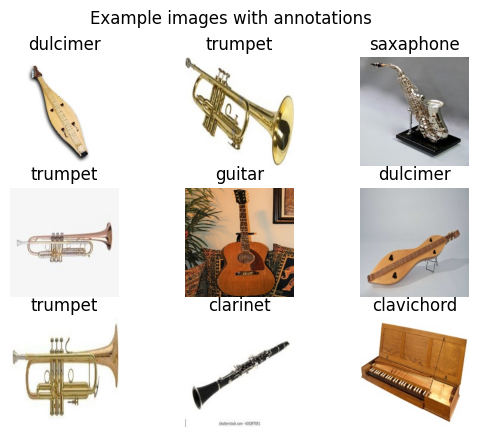

In [126]:
fig, ax = plt.subplots(3, 3)

for i in range(9):
    img, idx = full_dataset[i]
    ax = plt.subplot(3, 3, i + 1)
    image = Image.open(img)
    plt.imshow(np.array(image).astype("int16"))
    plt.title(idx_instruments[idx])
    plt.axis("off")
plt.suptitle("Example images with annotations")
plt.show()

## Example of image prediction

In [127]:
def softmax(values):
    exp_values = np.exp(values)
    exp_values_sum = np.sum(exp_values)
    return exp_values/exp_values_sum

def classify_photo_with_dl(img_path: str):
    logits = generate_image_embeddings_with_keras([img_path], keras_model_path="model.keras", batch_size=1)
    probs = softmax(logits)
    probs = [f'{round(100 * x)}%' for x in probs]
    return pd.DataFrame(probs, index=instrument_idxs.keys(), columns=['probability']).sort_values('probability', ascending = False).head()

def show_classification(df, img_path):
    img = Image.open(img_path)
    img = img.resize((224, 224))
    display.display(df)
    display.display(img)

  0%|          | 0/1 [00:00<?, ?it/s]

,probability
guitar,85%
sitar,8%
banjo,2%
violin,1%
piano,0%


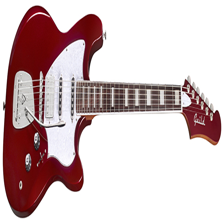

In [128]:
show_classification(classify_photo_with_dl("guitar.jpg"), 'guitar.jpg')

# Embeddings generated as nn clasifier output

In [21]:
scaler = MinMaxScaler()
norm_embeddings = scaler.fit_transform(image_embeddings)

In [22]:
reduced_embeddings_PCA = project_vectors(np.array(norm_embeddings), technique="pca", n_components=2, random_state=42)
reduced_embeddings_umap = project_vectors(np.array(norm_embeddings), technique="umap", n_components=2, random_state=42)

In [24]:
df_NNembedings_umap = pd.DataFrame(reduced_embeddings_umap, columns=["x", "y"])
df_NNembedings_umap["instrument"] = [idx_instruments[i] for i in labels_validate]

df_NNembedings_PCA = pd.DataFrame(reduced_embeddings_PCA, columns=["x", "y"])
df_NNembedings_PCA["instrument"] = [idx_instruments[i] for i in labels_validate]

In [25]:
cluster_df(df_NNembedings_umap, reduced_embeddings_umap)

KMeans ari: 0.938909389093891
AC ari: 0.9441167445190767


In [26]:
show_clusters(df_NNembedings_umap, f'Agglomerative Clustering with UMAP', 'AC')

In [27]:
cluster_df(df_NNembedings_PCA, reduced_embeddings_PCA)

KMeans ari: 0.38845298617845564
AC ari: 0.44985170389201623


In [28]:
show_clusters(df_NNembedings_PCA, "Agglomerative Clustering with PCA")

# Observations:
1. Clustering done on UMAP projections provides almost ideal ARI (0.94)
2. For both ResNet and Fine Tuned model projecting embeddings with PCA makes it harder to cluster, achieving much lower ARI

# Fine tuning EfficientNet model

In [16]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1)
])

In [17]:
image_size = (224, 224)
batch_size = 128

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)  # Resize as needed
    image = data_augmentation(image)
    return image, label

In [18]:
X_train, X_val, y_train, y_val = image_paths_train, image_paths_test, labels_train, labels_test

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000, reshuffle_each_iteration=True)
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

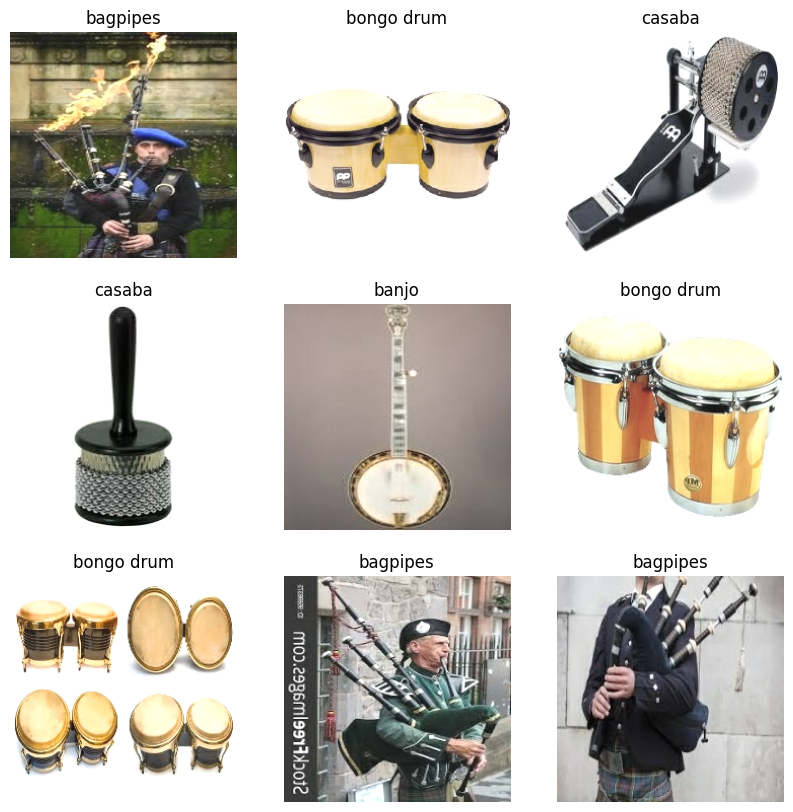

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("int16"))
        plt.title(instrument_idxs[labels[i].numpy()])
        plt.axis("off")

In [ ]:
base_model = keras.applications.EfficientNetB0(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = True

inputs = keras.Input(shape=image_size + (3,))
x = keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(20, activation=None)(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction="sum_over_batch_size"),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

#Save each model to choose the best one
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

In [ ]:
history = model.fit(
    train_ds,
    epochs=100,                  
    validation_data=test_ds,
    callbacks=callbacks
)